<a href="https://colab.research.google.com/github/pravda27/hacks_ai/blob/main/main_businessup_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузим нужные библиотеки и данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.metrics import recall_score, precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn import tree
import numpy as np
from sklearn.metrics import f1_score
from google.colab.data_table import DataTable
DataTable.max_columns = 80
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#%cd /content/drive/My Drive/Хакатоны/Yaro

Mounted at /content/drive


Данные

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hacks_ai/msk_obl/train_dataset_train.csv")
df_user = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hacks_ai/msk_obl/user.csv")
df_team = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hacks_ai/msk_obl/team_point.csv")
df_desicion = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hacks_ai/msk_obl/user_decision.csv")
ss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hacks_ai/msk_obl/sample_solution.csv")

## Рассмотрим датасет поближе

In [5]:
print(df_train.shape)
print(df_user.shape)
print(df_team.shape)
print(df_desicion.shape)
print(ss.shape)

(680, 5)
(973, 3)
(10986, 5)
(60228, 3)
(293, 5)


In [6]:
df_user.head(3)

,user_id,team_id,game_id
0,10189,1664,235
1,10018,1690,237
2,10580,1394,194


In [7]:
df_train.head(5)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0


In [8]:
df_team.head(5)

,team_id,category_id,period,score,place
0,1948,2,0,16,2
1,1934,3,4,45,6
2,1894,4,8,24,4
3,1688,4,0,27,4
4,1592,4,2,21,5


In [9]:
df_desicion.head(5)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420
3,10236,2,284
4,10130,3,72


In [10]:
ss.head(5)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0


Имеем 4 таблицы для исследования и обучения и 1 таблицу с id для теста:

# Базовый анализ

Заметим что в **решениях** есть период, где пользватели совершали больше действий

In [11]:
df_desicion.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение решений по периодам')

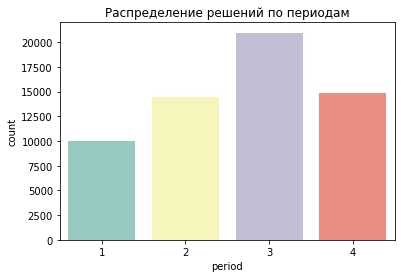

In [14]:
sns.countplot(x = "period" , data  = df_desicion, palette = "Set3").set_title('Распределение решений по периодам')

Text(0.5, 1.0, 'Распределение решений')

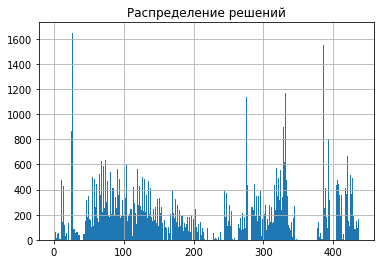

In [13]:
df_desicion["decision_id"].hist(bins = 300).set_title('Распределение решений')

Проанализируем таблицу **командных действий**

In [15]:
df_team['category_id'].value_counts()

2    1831
3    1831
4    1831
5    1831
6    1831
1    1831
Name: category_id, dtype: int64

In [16]:
df_team['period'].value_counts()

0    2130
4    2130
2    2130
1    2130
3    2130
5     138
8      66
7      66
6      66
Name: period, dtype: int64

In [17]:
df_team['score'].value_counts()

 27     482
 8      473
 16     437
 4      432
 103    381
       ... 
-60       1
 293      1
 311      1
 315      1
 349      1
Name: score, Length: 412, dtype: int64

In [18]:
df_team['place'].value_counts()

1    1922
2    1898
3    1874
4    1814
5    1740
6    1738
Name: place, dtype: int64

In [19]:
fff = df_team[df_team['team_id'] == 1948].sort_values(by=["category_id","period"])
fff

,team_id,category_id,period,score,place
6386,1948,1,0,4,2
2149,1948,1,1,2,4
4953,1948,1,2,-9,5
2059,1948,1,3,-4,5
7559,1948,1,4,-12,3
0,1948,2,0,16,2
8754,1948,2,1,9,4
4602,1948,2,2,-30,5
8512,1948,2,3,-19,5
9200,1948,2,4,-17,3


На примере одной команды видим, что в каждой категории есть 5 периодов за который выставляется своя оценка и место.
Посчитаем среднее место команды для каждой категории.

In [20]:
mean_place = df_team.pivot_table(index = ['team_id'], columns = 'category_id',values = 'place', aggfunc='mean').reset_index()
mean_place.rename(columns = {1 : 'cat1_mean_place', 2 : 'cat2_mean_place', 3 : 'cat3_mean_place', 4 : 'cat4_mean_place', 5 : 'cat5_mean_place', 6 : 'cat6_mean_place'}, inplace = True)
mean_place.head()

category_id,team_id,cat1_mean_place,cat2_mean_place,cat3_mean_place,cat4_mean_place,cat5_mean_place,cat6_mean_place
0,381,4.4,4.6,4.6,4.8,3.8,5.0
1,382,2.2,2.4,2.2,2.4,3.0,2.4
2,383,2.4,2.2,2.6,2.2,4.2,2.0
3,384,3.0,3.6,3.2,3.8,3.4,3.8
4,1232,5.2,4.6,5.2,4.6,1.6,5.2


### Предобработка перед обучением

Узнаем частоту команд участника в каждом периоде

In [21]:
df_desicion_train = df_desicion[df_desicion.user_id.map(lambda x:x in df_train.id.values)]
df_desicion_train.head()

,user_id,period,decision_id
0,10625,1,409
2,10775,4,420
3,10236,2,284
4,10130,3,72
5,10273,2,140


In [22]:
df_decision_count = df_desicion_train.groupby(by=["user_id",	"period"]).count()
df_decision_count.head(5)

decision_id
user_id period             
10001   1                29
        2                23
        3                39
        4                15
10003   1                21

In [23]:
#Принято решение не использовать, т.к. модель переобучается на количсетве решений за период

#for id in df_train.id.values:
#  for period in range(1,5):
#    try :
#      index = df_train[df_train.id == id].index[0]
#      df_train.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
#    except IndexError:
#      continue

In [24]:
df_train.head(3)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0


Присоединим team_id

In [25]:
df_train.rename(columns = {'id' : 'user_id'}, inplace = True)
df_train1 = pd.merge(df_train, df_user, on="user_id", how='left')
df_train1 = df_train1.drop(["game_id"], axis = 1) # удалим ненужный столбец

Присоелиним средние места команды по категориям

In [26]:
df_train2 = pd.merge(df_train1, mean_place, on="team_id", how='left')
df_train2.head(3)

,user_id,Analytical thinking,Systemic thinking,Adaptability,Focus,team_id,cat1_mean_place,cat2_mean_place,cat3_mean_place,cat4_mean_place,cat5_mean_place,cat6_mean_place
0,10884,4.0,4.0,4.0,4.0,1440,4.6,5.0,4.2,4.0,2.2,5.0
1,10106,5.0,4.0,5.0,5.0,1536,3.0,3.0,2.8,3.0,2.2,2.8
2,10438,6.0,5.0,5.0,5.0,1742,2.8,3.4,2.6,2.4,2.2,3.0


In [27]:
df_train = df_train.fillna(0)
df_train.shape

(680, 5)

Построим матрицу корреляций

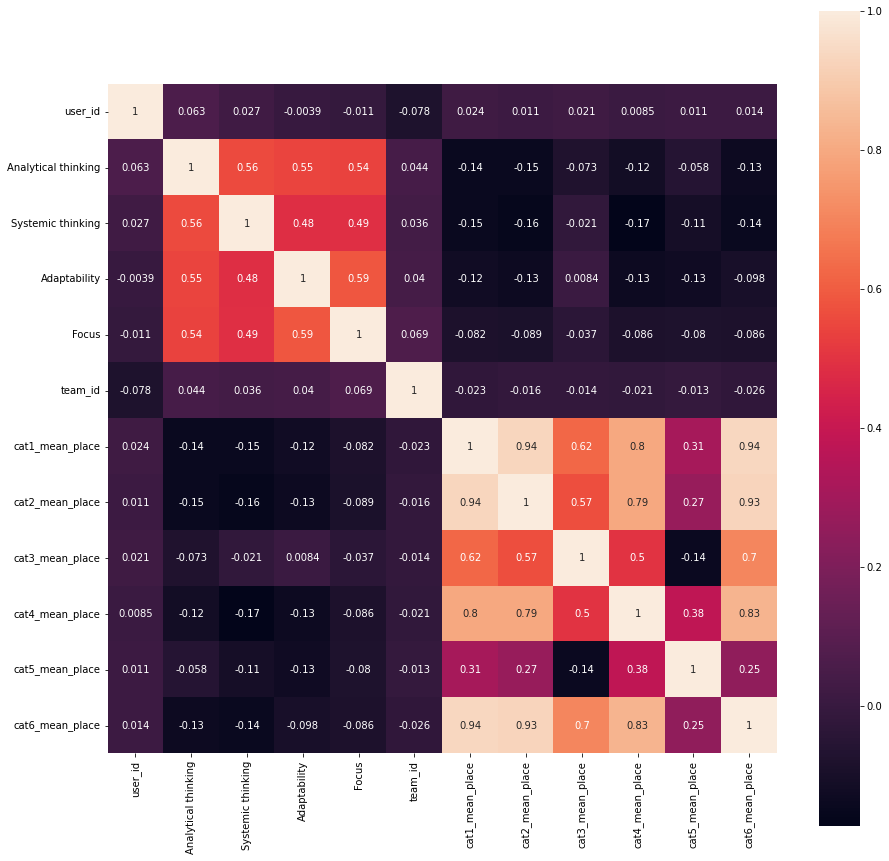

In [28]:
plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(df_train2.corr(), square = True, annot=True)

## Выделим выборки

In [ ]:
df_train.rename(columns = {'Analytical thinking' : 'krit_1', 'Systemic thinking' : 'krit_2','Adaptability' : 'krit_3', 'Focus' : 'krit_4'}, inplace = True)
df_train2.rename(columns = {'Analytical thinking' : 'krit_1', 'Systemic thinking' : 'krit_2','Adaptability' : 'krit_3', 'Focus' : 'krit_4'}, inplace = True)

In [ ]:
X = df_train2.drop(["krit_1",	"krit_2",	"krit_3",	"krit_4","user_id","team_id"], axis = 1)
y = df_train2[["krit_1",	"krit_2",	"krit_3",	"krit_4"]]
print(X.shape)

(680, 6)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение модели

In [ ]:
clf = RandomForestClassifier(random_state=0)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Оценка точности

In [ ]:
pred = clf.predict(X_test)

In [ ]:
result = 0 

for i in range(4):
  result += recall_score(y_test["krit_" + str(i+1)], pred[:,i], average='macro', zero_division=True)

print("Recall score",result/4)

Recall score 0.3130618095557789


Оптимизация гиперпараметров (оказалась неэффективна на данной выборке)

from sklearn.model_selection import GridSearchCV
n_estimators = [100,110,120]
max_features = ['sqrt']
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(clf, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_


pred_gs = gs.best_estimator_.predict(X_test)


result = 0 

for i in range(4):
  result += recall_score(y_test["krit_" + str(i+1)], pred_gs[:,i], average='macro', zero_division=True)

print("Recall score",result/4)

<h1>Проделаем те же манипуляции на тестовой выборке и сформируем файл с ответом</h1>

In [ ]:
df_sample_solution = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hacks_ai/msk_obl/sample_solution.csv")
ss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hacks_ai/msk_obl/sample_solution.csv")
ss.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0


In [ ]:
#не использовали
#ss_desicion = df_desicion[df_desicion.user_id.map(lambda x:x in ss.id.values)]
#ss_decision_count = df_desicion.groupby(by=["user_id",	"period"]).count()
#ss_decision_count.head(5)
#for id in ss.id.values:
#  for period in range(1,5):
#    try :
#      index = ss[ss.id == id].index[0]
#      ss.loc[index,"period_"+str(period)] = ss_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
#    except IndexError:
#      continue

In [ ]:
ss.rename(columns = {'Analytical thinking' : 'krit_1', 'Systemic thinking' : 'krit_2','Adaptability' : 'krit_3', 'Focus' : 'krit_4'}, inplace = True)
ss.rename(columns = {'id' : 'user_id'}, inplace = True)
ss = pd.merge(ss, df_user, on="user_id", how='left')
ss = ss.drop(["game_id"], axis = 1)
ss = pd.merge(ss, mean_place, on="team_id", how='left')
ss.head(3)

,user_id,krit_1,krit_2,krit_3,krit_4,team_id,cat1_mean_place,cat2_mean_place,cat3_mean_place,cat4_mean_place,cat5_mean_place,cat6_mean_place
0,10199,0,0,0,0,1912,3.6,3.8,3.4,3.8,2.8,3.8
1,10539,0,0,0,0,1458,3.8,3.6,3.2,4.0,4.0,4.0
2,10174,0,0,0,0,1348,1.4,1.8,1.4,1.8,2.2,1.8


In [ ]:
ss = ss.drop(["krit_1","krit_2","krit_3","krit_4","user_id","team_id"], axis = 1)

new_pred = clf.predict(ss)
new_pred

array([[4., 4., 5., 4.],
       [4., 4., 4., 4.],
       [4., 4., 5., 5.],
       ...,
       [4., 4., 4., 4.],
       [4., 4., 4., 4.],
       [4., 4., 5., 5.]])

In [ ]:
len(new_pred)

293

In [ ]:
dfn = pd.DataFrame(new_pred)
dfn.head()

,0,1,2,3
0,4.0,4.0,5.0,4.0
1,4.0,4.0,4.0,4.0
2,4.0,4.0,5.0,5.0
3,5.0,4.0,5.0,5.0
4,5.0,4.0,5.0,5.0


In [ ]:
df_sample_solution["Analytical thinking"] = dfn[0]
df_sample_solution["Systemic thinking"] = dfn[1]
df_sample_solution["Adaptability"] = dfn[2]
df_sample_solution["Focus"] = dfn[3]
df_sample_solution.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,4.0,4.0,5.0,4.0
1,10539,4.0,4.0,4.0,4.0
2,10174,4.0,4.0,5.0,5.0
3,10465,5.0,4.0,5.0,5.0
4,10066,5.0,4.0,5.0,5.0


In [ ]:
df_sample_solution.to_csv('ss_mosobl.csv', index = False)
from google.colab import files
files.download("ss_mosobl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>